# Multi-label stratified group k fold

In [ ]:
#pip install ordered-set

In [1]:
#3059 annotation missing, last 3466

import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO

#!pip install albumentations==0.4.6

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
from ordered_set import OrderedSet


In [2]:
%matplotlib inline

dataset_path  = '../data'
anns_file_path = dataset_path + '/' + 'train_all_new.json'

data = []
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())


anns = dataset['annotations']
categories = dataset['categories']

data = [ann['image_id'] for ann in anns]
data2 = [ann['id'] for ann in anns]
data3 = [ann['area'] for ann in anns]
data4 = [ann['category_id']for ann in anns]

cat_names = [cat['name'] for cat in categories]

df = pd.DataFrame({'image_id': data, 'id': data2, 'area': data3, 'category_id': data4})

coco = COCO(anns_file_path)

loading annotations into memory...
Done (t=3.78s)
creating index...
index created!


In [3]:
cat_ids = coco.getCatIds()

In [4]:
#겹쳐진 영역이 제거된 area 를 구하기 위한 코드 

area = []
img_ids = []
category_ids = []

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

for img_id in OrderedSet(df.image_id):
    _tmp = []
    image_infos = coco.loadImgs(img_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
 
    masks = np.zeros((image_infos["height"], image_infos["width"]))

    for ann in anns:
        className = get_classname(ann['category_id'], categories)
        pixel_value = cat_names.index(className)+1
        masks[coco.annToMask(ann) == 1] = pixel_value
        _tmp.append(ann['category_id'])
    category_ids.append(_tmp)
    img_ids.append(img_id)
    area.append(np.count_nonzero(masks!=0)) 
        
    

In [5]:
final_df =  pd.DataFrame({"image_id": img_ids, "area": area})
final_df

,image_id,area
0,0,133712
1,1,87568
2,2,33050
3,3,37984
4,4,107162
...,...,...
3461,3462,117226
3462,3463,59937
3463,3464,68798
3464,3465,168131


# 각 이미지 등장하는 카테고리의 수로 Labeling
- 한 이미지에 동일 카테고리가 여러번 등장하는 경우는 고려하지 않았다. 
- 레이블 수를 최소화하기 위한 결정

In [6]:
tmp = [len(set(category_num)) for category_num in category_ids]
final_df["category_count"] = tmp 
final_df

,image_id,area,category_count
0,0,133712,3
1,1,87568,2
2,2,33050,1
3,3,37984,2
4,4,107162,1
...,...,...,...
3461,3462,117226,4
3462,3463,59937,2
3463,3464,68798,1
3464,3465,168131,4


In [7]:
final_df = final_df.sort_values("area").reset_index()
final_df

,index,image_id,area,category_count
0,256,256,2186,2
1,2564,2564,2617,1
2,3286,3287,2691,1
3,248,248,3015,1
4,263,263,3465,1
...,...,...,...,...
3461,1229,1229,260447,2
3462,3157,3158,260726,4
3463,2635,2635,260822,2
3464,2736,2736,260882,3


# 각 이미지의 Area 크기로 Labeling

In [8]:
#area 크기를 기준으로 나누기전에 mean 찍어보기 
# 총 이미지 개수 3466 
# 33퍼, 33퍼, 34퍼 
# 1155 2310 3466
print(final_df.loc[:1155]["area"].mean()) #36624.9
print(final_df.loc[1155: 2310]["area"].mean()) #72762
print(final_df.loc[2310: 3466]["area"].mean()) #128316.4

36624.9723183391
72762.77249134947
128316.46193771626


In [9]:
#area 크기를 기준으로 나누기#
final_df.loc[:3466, "area_size"] = 3
final_df.loc[:2310, "area_size"] = 2
final_df.loc[:1155, "area_size"] = 1

In [10]:
#Annotation에 area 크기 기준으로 나눈 labeling 기록 
for index, row in final_df.iterrows():
    tmp = df["image_id"] == row["image_id"]
    df.loc[tmp, "category_count"] = row["category_count"]
    df.loc[tmp, "area_size"] = row["area_size"]

In [11]:
df.category_count.value_counts()

4.0    6248
3.0    6112
2.0    4808
5.0    4357
1.0    2774
6.0    2253
7.0     300
8.0      79
Name: category_count, dtype: int64

In [12]:
print(len(df[df["area_size"] == 1]))
print(len(df[df["area_size"] == 2]))
print(len(df[df["area_size"] == 3]))
print(len(df))

#작은 이미지 개수 == 중간 이미지 개수== 큰 이미지 개수
#큰 이미지 annotation 수 > 중간 이미지 annotation 수 > 작은 annotation 수 
 

3341
8509
15081
26931


In [13]:
df

,image_id,id,area,category_id,category_count,area_size
0,0,0,6307.5,8,3.0,3.0
1,0,1,3313.5,8,3.0,3.0
2,0,2,4741.0,6,3.0,3.0
3,0,3,18560.5,5,3.0,3.0
4,0,4,9759.0,5,3.0,3.0
...,...,...,...,...,...,...
26926,3466,27089,4672.0,2,3.0,3.0
26927,3466,27090,6968.0,6,3.0,3.0
26928,3466,27091,32018.0,6,3.0,3.0
26929,3466,27092,19037.5,8,3.0,3.0


In [14]:
df = df.sort_values('area_size')
df.reset_index(inplace = True)

In [15]:
df

,index,image_id,id,area,category_id,category_count,area_size
0,23682,2550,23812,10600.0,4,1.0,1.0
1,3818,887,3872,2275.5,1,3.0,1.0
2,3819,888,3873,4963.5,6,4.0,1.0
3,3820,888,3874,4069.5,6,4.0,1.0
4,3821,888,3875,1067.5,1,4.0,1.0
...,...,...,...,...,...,...,...
26926,11981,1611,12057,304.5,6,4.0,3.0
26927,11980,1611,12056,5116.0,6,4.0,3.0
26928,11979,1611,12055,702.5,6,4.0,3.0
26929,11986,1611,12062,2682.5,6,4.0,3.0


# Multi-label

In [16]:
# category_count  [1,8]
# area_size [1,3]
# category_id [1,10]

# 8 * 3 * 10 = 240 
#1,2,3,4,5,6,7... 240 

label = []
for a,b,c in zip(df["category_count"], df["area_size"], df["category_id"]):
    label.append( 30*(a-1) + 10*(b-1) + c)

In [17]:
df["label"] = label
df

,index,image_id,id,area,category_id,category_count,area_size,label
0,23682,2550,23812,10600.0,4,1.0,1.0,4.0
1,3818,887,3872,2275.5,1,3.0,1.0,61.0
2,3819,888,3873,4963.5,6,4.0,1.0,96.0
3,3820,888,3874,4069.5,6,4.0,1.0,96.0
4,3821,888,3875,1067.5,1,4.0,1.0,91.0
...,...,...,...,...,...,...,...,...
26926,11981,1611,12057,304.5,6,4.0,3.0,116.0
26927,11980,1611,12056,5116.0,6,4.0,3.0,116.0
26928,11979,1611,12055,702.5,6,4.0,3.0,116.0
26929,11986,1611,12062,2682.5,6,4.0,3.0,116.0


# 분포 찍어보기

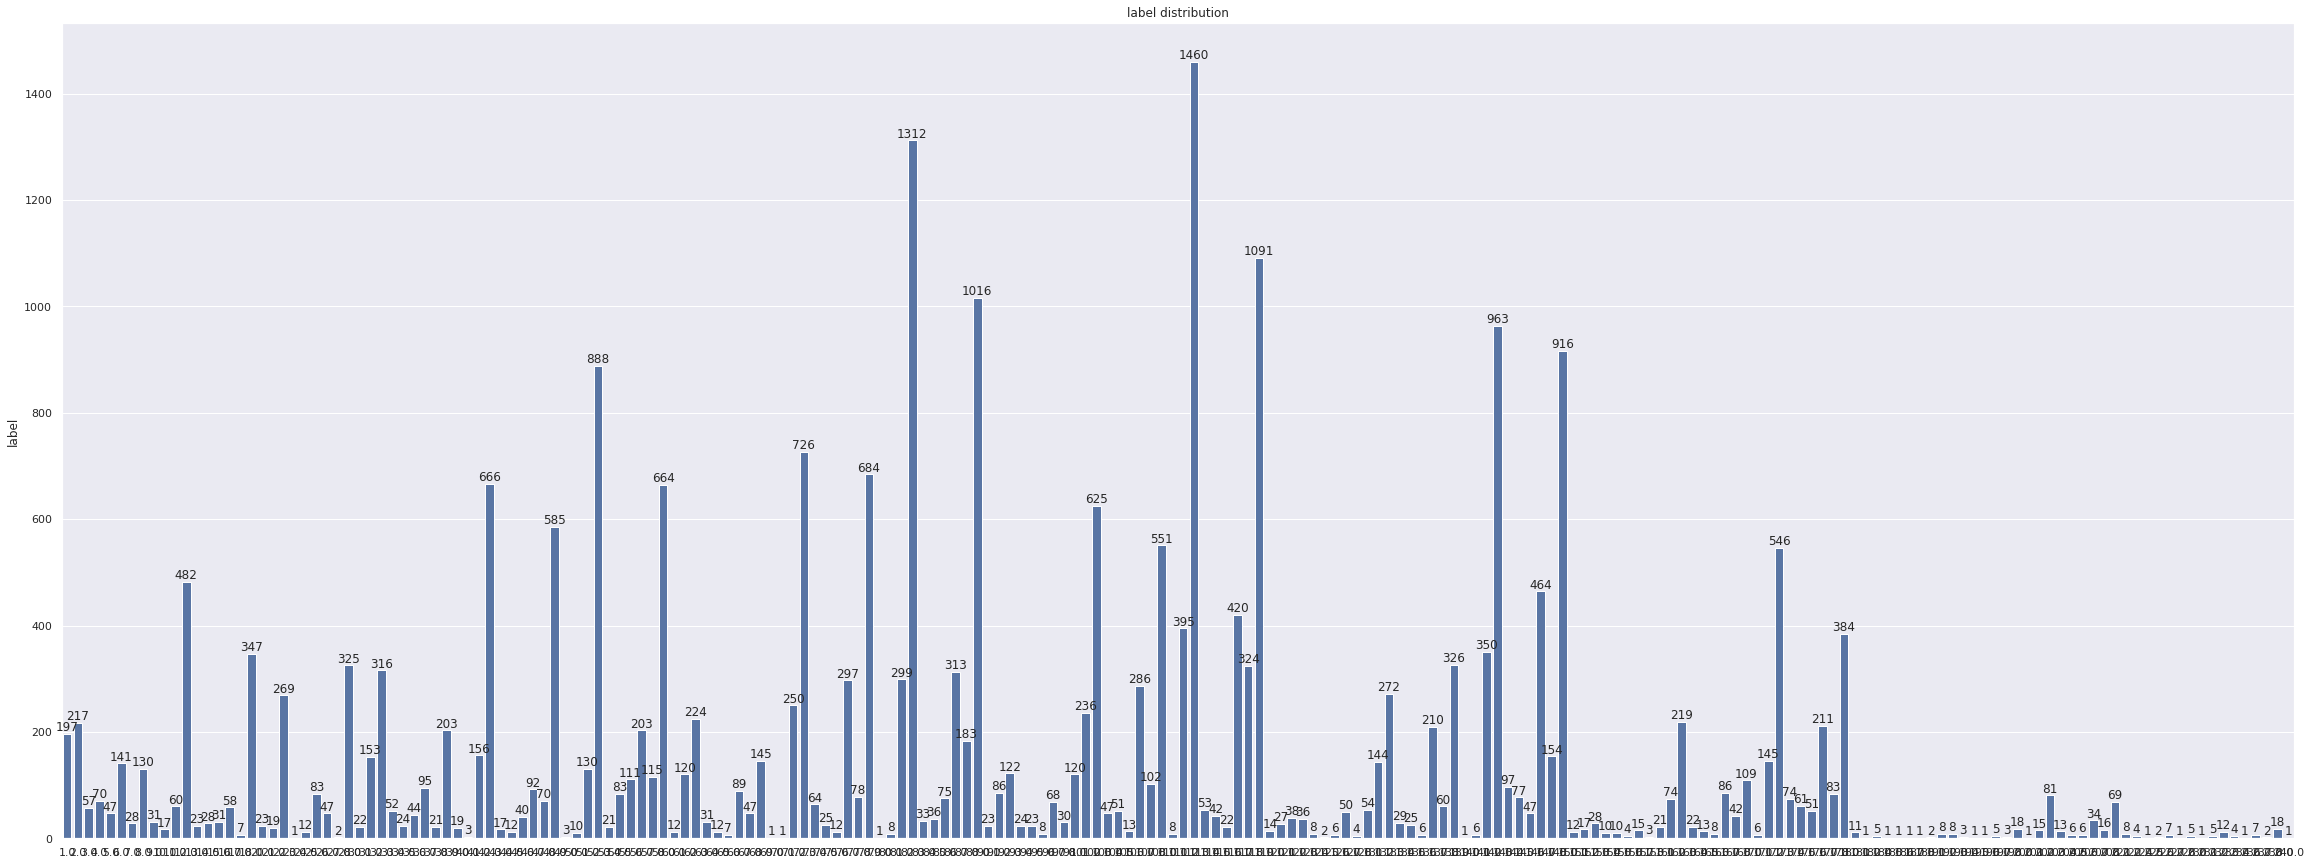

In [18]:
sns.set(rc = {'figure.figsize':(40,15)})

plt.title("label distribution")
plot_1 = sns.barplot(x= df["label"].value_counts().sort_index().index , y = df["label"].value_counts().sort_index() ,data=df , label="Total", color="b")
plot_1.bar_label(plot_1.containers[0])
print()

In [19]:
df = df.sort_values('image_id').reset_index()

In [20]:
df

,level_0,index,image_id,id,area,category_id,category_count,area_size,label
0,20413,14,0,14,11280.0,8,3.0,3.0,88.0
1,20414,13,0,13,1099.0,8,3.0,3.0,88.0
2,20415,12,0,12,4584.0,8,3.0,3.0,88.0
3,20416,11,0,11,1628.0,8,3.0,3.0,88.0
4,17170,0,0,0,6307.5,8,3.0,3.0,88.0
...,...,...,...,...,...,...,...,...,...
26926,14519,26924,3466,27087,2329.0,6,3.0,3.0,86.0
26927,14518,26923,3466,27086,6710.0,6,3.0,3.0,86.0
26928,14517,26922,3466,27085,15722.5,6,3.0,3.0,86.0
26929,26155,26929,3466,27092,19037.5,8,3.0,3.0,88.0


## multi-label stratified group k fold

In [21]:
import json 
import numpy as np 
from sklearn.model_selection import StratifiedGroupKFold 
import copy
from ordered_set import OrderedSet

#from iterstrat.ml_stratifiers import StratifiedGroupKFold


# load json annotation = {dataset file 경로} 

with open('../data/train_all_new.json') as f: data = json.load(f)

X = np.ones((len(df),1))
y = np.array(df["label"]).astype(int)
groups = np.array(df["image_id"])

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=411) 

idx = 0
id_train = 0
id_val = 0
img_train = 0
img_val = 0
img_id_train = 0 
img_id_val = 0 
tmp = 0 

for train_idx, val_idx in cv.split(X, y, groups):
    tmp_data = copy.deepcopy(data)
   

    print("TRAIN:", groups[train_idx])
    print("      ", y[train_idx])
    print(" TEST:", groups[val_idx])
    print("      ", y[val_idx])
    
    
    # 확인 결과, 하나의 train, validation dataset에서 겹치는 이미지는 없는 것으로 확인됨.
    print(set(groups[train_idx]) & set(groups[val_idx]))

    train = dict()
    val = dict()

    # make train dataset
    train['images'] = [tmp_data['images'][i] for i in OrderedSet(groups[train_idx])]
    train['categories'] = tmp_data['categories']
    for img in train['images']:
        img['id'] = img_train
        img_train += 1
        
    train['annotations'] = [tmp_data['annotations'][i] for i in train_idx]
    

    for ann, n_ann in zip(train['annotations'], train['annotations'][1:]+[{"image_id": None}]):
        ann['id'] = id_train
        id_train += 1
        if ann['image_id'] == n_ann['image_id']:
            ann['image_id'] = img_id_train
            continue
        ann['image_id'] = img_id_train
        img_id_train += 1
        
            

    with open(f'../data/train_{idx}.json', 'w') as make_file:
        json.dump(train, make_file, indent='\t')
    
    
    tmp_data2 = copy.deepcopy(data)
    
    
    #make validation dataset
    val['images'] = [tmp_data2['images'][i] for i in OrderedSet(groups[val_idx])] 
    
    val['categories'] = tmp_data2['categories']
    
    #annotation id 로 만든 image 번호랑 다른 것. 
    #annotation id 로 가져온 image 번호랑 
    
    val['annotations'] = [tmp_data2['annotations'][i] for i in val_idx]

    
    for img in val['images']:
        img['id'] = img_val
        img_val += 1
        
    
    for ann, n_ann in zip(val['annotations'], val['annotations'][1:]+[{"image_id": None}]):
        ann['id'] = id_val
        id_val += 1
        if ann['image_id'] == n_ann['image_id']:
            ann['image_id'] = img_id_val
            continue
        ann['image_id'] = img_id_val
        img_id_val += 1
    
    
    

    with open(f'../data/val_{idx}.json', 'w') as make_file2:
        json.dump(val, make_file2, indent='\t')

    idx += 1
    id_train = 0
    id_val = 0
    img_train = 0
    img_val = 0
    img_id_train = 0 
    img_id_val = 0 

TRAIN: [   0    0    0 ... 3466 3466 3466]
       [88 88 88 ... 86 88 82]
 TEST: [   2    3    3 ... 3464 3464 3464]
       [ 6 36 34 ... 12 12 12]
set()
TRAIN: [   0    0    0 ... 3464 3464 3464]
       [88 88 88 ... 12 12 12]
 TEST: [   1    1    1 ... 3466 3466 3466]
       [48 48 41 ... 86 88 82]
set()
TRAIN: [   1    1    1 ... 3466 3466 3466]
       [48 48 41 ... 86 88 82]
 TEST: [   0    0    0 ... 3462 3462 3462]
       [ 88  88  88 ... 116 111 111]
set()
TRAIN: [   0    0    0 ... 3466 3466 3466]
       [88 88 88 ... 86 88 82]
 TEST: [  21   21   21 ... 3458 3458 3460]
       [48 48 41 ... 26 26  6]
set()
TRAIN: [   0    0    0 ... 3466 3466 3466]
       [88 88 88 ... 86 88 82]
 TEST: [   6   15   15 ... 3461 3461 3461]
       [ 1 42 48 ... 51 51 52]
set()


In [22]:
categories

[{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

# Category 비율로 찍어보기

In [23]:
from collections import Counter
import pandas as pd
#30*(a-1) + 10*(b-1) + c)
def get_distribution(y): 
    y_distr = Counter(y)
    print(y_distr)
    y_vals_sum = sum(y_distr.values()) 
    
    return [f'{y_distr[i]/y_vals_sum:.2%}' for i in range(np.max(y)+1)]

with open(f'../data/train_all_new.json') as f: train = json.load(f)
y = [ann['category_id'] for ann in train['annotations']]

distrs = [get_distribution(y)]
index = ['training set']

for i in range(5): 
    print(f"fold{i}")
    with open(f'../data/train_{i}.json') as f: train = json.load(f)
    with open(f'../data/val_{i}.json') as f: validation = json.load(f)
    
    train_y = [ann['category_id'] for ann in train['annotations']]
    val_y = [ann['category_id'] for ann in validation['annotations']]
    

    # train_gr, val_gr = groups[train_idx], groups[val_idx]

    # assert len(set(train_gr) & set(val_gr)) == 0
    distrs.append(get_distribution(train_y)) 
    distrs.append(get_distribution(val_y))
    index.append(f'train - fold{i}')
    index.append(f'val - fold{i}')
    
categories = [d['name'] for d in data['categories']] 
#categories.insert(0,None)
pd.DataFrame( np.array(distrs)[:,1:] , index=index, columns = [ categories[i] for i in range(np.max(y))] )

Counter({2: 9481, 8: 7783, 6: 3199, 1: 2906, 7: 1376, 3: 683, 5: 625, 4: 616, 10: 192, 9: 70})
fold0
Counter({2: 7687, 8: 6215, 6: 2466, 1: 2308, 7: 1083, 3: 524, 4: 483, 5: 471, 10: 162, 9: 57})
Counter({2: 1794, 8: 1568, 6: 733, 1: 598, 7: 293, 3: 159, 5: 154, 4: 133, 10: 30, 9: 13})
fold1
Counter({2: 7633, 8: 6223, 6: 2624, 1: 2307, 7: 1035, 3: 524, 4: 520, 5: 485, 10: 163, 9: 68})
Counter({2: 1848, 8: 1560, 1: 599, 6: 575, 7: 341, 3: 159, 5: 140, 4: 96, 10: 29, 9: 2})
fold2
Counter({2: 7777, 8: 6310, 6: 2692, 1: 2355, 7: 1148, 3: 559, 5: 543, 4: 502, 10: 155, 9: 33})
Counter({2: 1704, 8: 1473, 1: 551, 6: 507, 7: 228, 3: 124, 4: 114, 5: 82, 10: 37, 9: 37})
fold3
Counter({2: 7371, 8: 6120, 6: 2474, 1: 2300, 7: 1125, 3: 539, 4: 507, 5: 461, 10: 141, 9: 59})
Counter({2: 2110, 8: 1663, 6: 725, 1: 606, 7: 251, 5: 164, 3: 144, 4: 109, 10: 51, 9: 11})
fold4
Counter({2: 7456, 8: 6264, 6: 2540, 1: 2354, 7: 1113, 3: 586, 5: 540, 4: 452, 10: 147, 9: 63})
Counter({2: 2025, 8: 1519, 6: 659, 1: 5

,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
training set,10.79%,35.20%,2.54%,2.29%,2.32%,11.88%,5.11%,28.90%,0.26%,0.71%
train - fold0,10.76%,35.83%,2.44%,2.25%,2.20%,11.49%,5.05%,28.97%,0.27%,0.76%
val - fold0,10.92%,32.77%,2.90%,2.43%,2.81%,13.39%,5.35%,28.64%,0.24%,0.55%
train - fold1,10.69%,35.37%,2.43%,2.41%,2.25%,12.16%,4.80%,28.83%,0.32%,0.76%
val - fold1,11.20%,34.55%,2.97%,1.79%,2.62%,10.75%,6.38%,29.16%,0.04%,0.54%
train - fold2,10.67%,35.23%,2.53%,2.27%,2.46%,12.20%,5.20%,28.59%,0.15%,0.70%
val - fold2,11.34%,35.08%,2.55%,2.35%,1.69%,10.44%,4.69%,30.33%,0.76%,0.76%
train - fold3,10.90%,34.94%,2.55%,2.40%,2.19%,11.73%,5.33%,29.01%,0.28%,0.67%
val - fold3,10.39%,36.17%,2.47%,1.87%,2.81%,12.43%,4.30%,28.51%,0.19%,0.87%
train - fold4,10.94%,34.65%,2.72%,2.10%,2.51%,11.81%,5.17%,29.11%,0.29%,0.68%


## stratified group k fold

In [161]:
import json 
import numpy as np 
from sklearn.model_selection import StratifiedGroupKFold 
#from iterstrat.ml_stratifiers import StratifiedGroupKFold


# load json annotation = {dataset file 경로} 

with open('../data/train_all_new.json') as f: data = json.load(f)


var = [(ann['image_id'], ann['category_id']) for ann in dataset['annotations']]
X = np.ones((len(data['annotations']),1))
y = np.array([v[1] for v in var])
groups = np.array([v[0] for v in var]) 


cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=411) 

idx = 0
for train_idx, val_idx in cv.split(X, y, groups):
    print("TRAIN:", groups[train_idx])
    print("      ", y[train_idx])
    print(" TEST:", groups[val_idx])
    print("      ", y[val_idx])
    
    
    # 확인 결과, 하나의 train, validation dataset에서 겹치는 이미지는 없는 것으로 확인됨.
    print(set(groups[train_idx]) & set(groups[val_idx]))

    train = dict()
    val = dict()

    # make train dataset
    train['images'] = [data['images'][i] for i in set(groups[train_idx])]
    train['categories'] = data['categories']
    train['annotations'] = [data['annotations'][i] for i in train_idx]

    with open(f'../data/train{idx}.json', 'w') as make_file:
        json.dump(train, make_file, indent='\t')

    #make validation dataset
    val['images'] = [data['images'][i] for i in set(groups[val_idx])]
    val['categories'] = data['categories']
    val['annotations'] = [data['annotations'][i] for i in val_idx]

    with open(f'../data/val{idx}.json', 'w') as make_file2:
        json.dump(val, make_file2, indent='\t')

    idx += 1

TRAIN: [   0    0    0 ... 3464 3464 3464]
       [8 8 6 ... 2 2 2]
 TEST: [   1    1    1 ... 3466 3466 3466]
       [8 8 8 ... 6 8 2]
set()
TRAIN: [   0    0    0 ... 3466 3466 3466]
       [8 8 6 ... 6 8 2]
 TEST: [   4    4   10 ... 3456 3456 3456]
       [6 6 3 ... 6 6 6]
set()
TRAIN: [   1    1    1 ... 3466 3466 3466]
       [8 8 8 ... 6 8 2]
 TEST: [   0    0    0 ... 3464 3464 3464]
       [8 8 6 ... 2 2 2]
set()
TRAIN: [   0    0    0 ... 3466 3466 3466]
       [8 8 6 ... 6 8 2]
 TEST: [   5    5   11 ... 3461 3461 3461]
       [2 6 4 ... 2 1 1]
set()
TRAIN: [   0    0    0 ... 3466 3466 3466]
       [8 8 6 ... 6 8 2]
 TEST: [   2    7    8 ... 3463 3463 3463]
       [6 1 1 ... 7 1 1]
set()


In [162]:
from collections import Counter
import pandas as pd
#30*(a-1) + 10*(b-1) + c)
def get_distribution(y): 
    y_distr = Counter(y)
    print(y_distr)
    y_vals_sum = sum(y_distr.values()) 
    
    return [f'{y_distr[i]/y_vals_sum:.2%}' for i in range(np.max(y)+1)]

with open(f'../data/train_all_new.json') as f: train = json.load(f)
y = [ann['category_id'] for ann in train['annotations']]

distrs = [get_distribution(y)]
index = ['training set']

for i in range(5): 
    print(f"fold{i}")
    with open(f'../data/train{i}.json') as f: train = json.load(f)
    with open(f'../data/val{i}.json') as f: validation = json.load(f)
    
    train_y = [ann['category_id'] for ann in train['annotations']]
    val_y = [ann['category_id'] for ann in validation['annotations']]
    

    # train_gr, val_gr = groups[train_idx], groups[val_idx]

    # assert len(set(train_gr) & set(val_gr)) == 0
    distrs.append(get_distribution(train_y)) 
    distrs.append(get_distribution(val_y))
    index.append(f'train - fold{fold_ind}')
    index.append(f'val - fold{fold_ind}')
    
categories = [d['name'] for d in data['categories']] 
#categories.insert(0,None)
pd.DataFrame( np.array(distrs)[:,1:] , index=index, columns = [ categories[i] for i in range(np.max(y))] )

Counter({2: 9481, 8: 7783, 6: 3199, 1: 2906, 7: 1376, 3: 683, 5: 625, 4: 616, 10: 192, 9: 70})
fold0
Counter({2: 7744, 8: 6108, 6: 2479, 1: 2325, 7: 1092, 3: 554, 5: 534, 4: 493, 10: 161, 9: 48})
Counter({2: 1737, 8: 1675, 6: 720, 1: 581, 7: 284, 3: 129, 4: 123, 5: 91, 10: 31, 9: 22})
fold1
Counter({2: 7460, 8: 6227, 6: 2641, 1: 2332, 7: 1069, 3: 561, 4: 507, 5: 469, 10: 145, 9: 53})
Counter({2: 2021, 8: 1556, 1: 574, 6: 558, 7: 307, 5: 156, 3: 122, 4: 109, 10: 47, 9: 17})
fold2
Counter({2: 7494, 8: 6329, 6: 2644, 1: 2331, 7: 1141, 3: 551, 5: 492, 4: 486, 10: 161, 9: 54})
Counter({2: 1987, 8: 1454, 1: 575, 6: 555, 7: 235, 5: 133, 3: 132, 4: 130, 10: 31, 9: 16})
fold3
Counter({2: 7522, 8: 6315, 6: 2524, 1: 2335, 7: 1070, 3: 555, 5: 479, 4: 479, 10: 146, 9: 63})
Counter({2: 1959, 8: 1468, 6: 675, 1: 571, 7: 306, 5: 146, 4: 137, 3: 128, 10: 46, 9: 7})
fold4
Counter({2: 7704, 8: 6153, 6: 2508, 1: 2301, 7: 1132, 5: 526, 3: 511, 4: 499, 10: 155, 9: 62})
Counter({2: 1777, 8: 1630, 6: 691, 1: 

,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
training set,10.79%,35.20%,2.54%,2.29%,2.32%,11.88%,5.11%,28.90%,0.26%,0.71%
train - fold4,10.79%,35.96%,2.57%,2.29%,2.48%,11.51%,5.07%,28.36%,0.22%,0.75%
val - fold4,10.77%,32.21%,2.39%,2.28%,1.69%,13.35%,5.27%,31.06%,0.41%,0.57%
train - fold4,10.86%,34.76%,2.61%,2.36%,2.19%,12.30%,4.98%,29.01%,0.25%,0.68%
val - fold4,10.50%,36.97%,2.23%,1.99%,2.85%,10.21%,5.62%,28.46%,0.31%,0.86%
train - fold4,10.75%,34.56%,2.54%,2.24%,2.27%,12.19%,5.26%,29.19%,0.25%,0.74%
val - fold4,10.96%,37.86%,2.52%,2.48%,2.53%,10.58%,4.48%,27.71%,0.30%,0.59%
train - fold4,10.87%,35.01%,2.58%,2.23%,2.23%,11.75%,4.98%,29.39%,0.29%,0.68%
val - fold4,10.49%,35.99%,2.35%,2.52%,2.68%,12.40%,5.62%,26.97%,0.13%,0.85%
train - fold4,10.68%,35.75%,2.37%,2.32%,2.44%,11.64%,5.25%,28.55%,0.29%,0.72%


# 기존 데이터셋 

In [175]:
from collections import Counter
import pandas as pd


def get_distribution(y): 
    y_distr = Counter(y)
    print(y_distr)
    y_vals_sum = sum(y_distr.values()) 
    
    return [f'{y_distr[i]/y_vals_sum:.2%}' for i in range(np.max(y)+1)]

with open(f'../data/train.json') as f: train = json.load(f)
with open(f'../data/val.json') as f: val = json.load(f)
with open(f'../data/train_all_new.json') as f: train_all = json.load(f)

t_a = [ann['category_id'] for ann in train_all['annotations']]
t_y = [ann['category_id'] for ann in train['annotations']]
v_y = [ann['category_id'] for ann in val['annotations']]

#t_distrs = [get_distribution(t_y)]
#v_distrs = [get_distribution(v_y)]

distrs = [get_distribution(t_a)]
index = ['training set']

# train_gr, val_gr = groups[train_idx], groups[val_idx]

# assert len(set(train_gr) & set(val_gr)) == 0
distrs.append(get_distribution(t_y)) 
distrs.append(get_distribution(v_y))
index.append(f'train - fold')
index.append(f'val - fold')
    
categories = [d['name'] for d in data['categories']] 
print(distrs)

#categories.insert(0,None)
pd.DataFrame( np.array(distrs)[:,1:] , index=index, columns = [ categories[i] for i in range(np.max(y))] )

Counter({2: 9481, 8: 7783, 6: 3199, 1: 2906, 7: 1376, 3: 683, 5: 625, 4: 616, 10: 192, 9: 70})
Counter({2: 7448, 8: 6114, 6: 2472, 1: 2225, 7: 1074, 3: 527, 5: 488, 4: 449, 10: 141, 9: 50})
Counter({2: 1863, 8: 1529, 6: 618, 1: 557, 7: 269, 3: 132, 5: 122, 4: 113, 10: 36, 9: 13})
[['0.00%', '10.79%', '35.20%', '2.54%', '2.29%', '2.32%', '11.88%', '5.11%', '28.90%', '0.26%', '0.71%'], ['0.00%', '10.60%', '35.49%', '2.51%', '2.14%', '2.33%', '11.78%', '5.12%', '29.13%', '0.24%', '0.67%'], ['0.00%', '10.61%', '35.47%', '2.51%', '2.15%', '2.32%', '11.77%', '5.12%', '29.11%', '0.25%', '0.69%']]


,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
training set,10.79%,35.20%,2.54%,2.29%,2.32%,11.88%,5.11%,28.90%,0.26%,0.71%
train - fold,10.60%,35.49%,2.51%,2.14%,2.33%,11.78%,5.12%,29.13%,0.24%,0.67%
val - fold,10.61%,35.47%,2.51%,2.15%,2.32%,11.77%,5.12%,29.11%,0.25%,0.69%
